A standalone notebook to plot saved results of simulations to reproduce Kozlowski+2017 Fig.2 

### Necessary imports : 

In [3]:
import numpy as np 
import os 
import datetime
import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from itertools import product
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

### Load the results 

Print single-panel Fig.2 - like results : 

In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 60}


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log10


In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 200}
In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 1000}
In this simulation we used the following settings:
 {'noise': 0.01, 'sampling': 'random', 'N_obs': 60}
In this simulation we used the following settings:
 {'noise': 0.01, 'sampling': 'random', 'N_obs': 200}
In this simulation we used the following settings:
 {'noise': 0.01, 'sampling': 'random', 'N_obs': 1000}
In this simulation we used the following settings:
 {'noise': 0.1, 'sampling': 'random', 'N_obs': 60}
In this simulation we used the following settings:
 {'noise': 0.1, 'sampling': 'random', 'N_obs': 200}
In this simulation we used the following settings:
 {'noise': 0.1, 'sampling': 'random', 'N_obs': 1000}


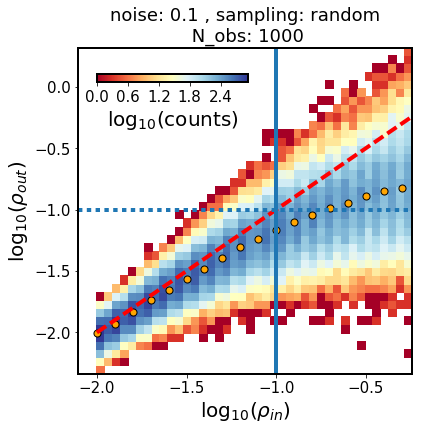

In [74]:
outDir = '../data_products/DRW_Kozlowski_Simulate/'
# load results to print ...

#sampling  = 'regular'
#noise = 0.01
#N_obs = 1000 

set_lims = False  
xmin, xmax = -2.1, 0.5 # in logspace 
ymin, ymax = -2.3, 0.6

for sampling, noise, N_obs in product(['random'],   # or 'regular'
                                      [0.001, 0.01, 0.1], 
                                     [60,200,1000 ]):

    fname  = outDir+'Celerite_fit_params_'+sampling+str(noise)+str(N_obs)+'.npy'    
    params = np.load(fname).item()
    print('In this simulation we used the following settings:\n',params)
    fname = outDir+'Celerite_fit_results_'+sampling+str(noise)+str(N_obs)+'.npy'
    results = np.load(fname)

    # Flatten the dictionary ... 
    rho_in = np.zeros(0) 
    rho_out = np.zeros(0) 

    for i in range(len(results)):
        rho_in = np.append(rho_in,  results[i]['rho_in'])
        rho_out = np.append(rho_out, results[i]['rho_out'])
        
    # Plot the 2D histogram...
    %matplotlib inline
    from scipy.stats import binned_statistic_2d
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    if set_lims  :
        print('Limiting x and y ')
        mask_x = (xmin < x ) * ( x < xmax )   
        mask_y = (ymin < y) * (y < ymax)
        mask_xy = mask_x * mask_y
        x = x[mask_xy]
        y = y[mask_xy]
        
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))

    cax = fig.add_axes([0.17, 0.8, 0.35,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax.set_ylabel(r'$\log_{10}(\rho_{out})$')
    
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='--', lw=4, color='red')
    ax.axhline(-1, ls=':', lw=4)
    ax.axvline(-1, ls='-', lw=4)
    
    if set_lims  : 
        ax.set_xlim(-2.1, 0.5)
        ax.set_ylim(-2.3, 0.6)


    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.scatter(mean_x[:-1], median_y[:-1], c = 'orange', s=50 , edgecolor='black')

    ax.set_title('noise: '+ str(params['noise'])+' '+\
                 ', sampling: '+ params['sampling'] +\
                 '\n N_obs: '+str(params['N_obs']) )
    if set_lims : 
        plt.savefig(outDir+'Celerite_fits_lims_'+sampling+'_'+\
                    str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')
    else : 
        plt.savefig(outDir+'Celerite_fits_'+sampling+'_'+\
                    str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')

Combine panels to illustrate the trends :
    
    a) keep N= 1000, random sampling,  and iterate over noise 
    b) keep noise at 0.001, random sampling, and iterate over number of points

In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 1000}


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


In this simulation we used the following settings:
 {'noise': 0.01, 'sampling': 'random', 'N_obs': 1000}
In this simulation we used the following settings:
 {'noise': 0.1, 'sampling': 'random', 'N_obs': 1000}


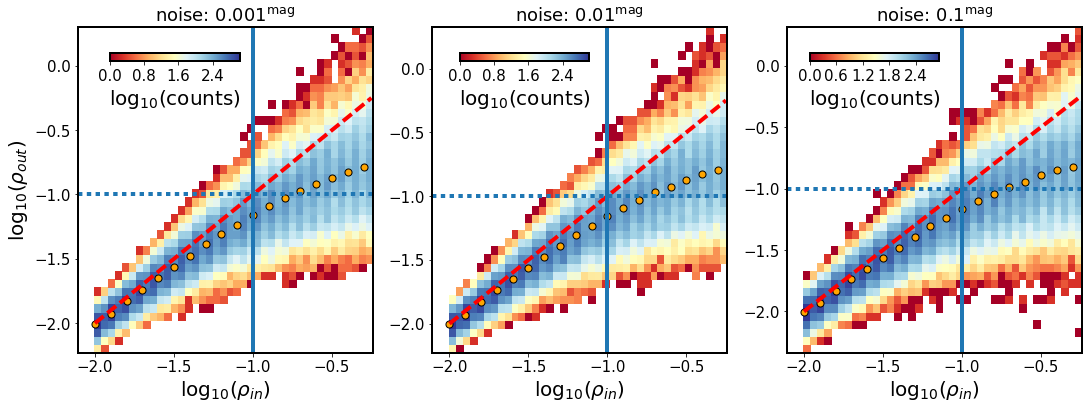

In [29]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

outDir = '../data_products/DRW_Kozlowski_Simulate/fit_results/'

# a ) keep N= 1000, random sampling , iterate over noise .... 

set_lims = False  
xmin, xmax = -2.1, 0.5 # in logspace 
ymin, ymax = -2.3, 0.6
sampling = 'random'
N_obs  =1000
# colorbar x0 location ... 
x0_cax = [0.15, 0.42, 0.69]

fig,axs = plt.subplots(1,3,figsize=(18,6))
col = 0
for noise in [0.001, 0.01, 0.1] :
    
    # select axis 
    ax = axs[col]
    
    # read-in the results... 
    fname  = outDir+'Celerite_fit_params_'+sampling+str(noise)+str(N_obs)+'.npy'    
    params = np.load(fname).item()
    print('In this simulation we used the following settings:\n',params)
    fname = outDir+'Celerite_fit_results_'+sampling+str(noise)+str(N_obs)+'.npy'
    results = np.load(fname)
    
    # Flatten the dictionary ... 
    rho_in = np.zeros(0) 
    rho_out = np.zeros(0) 

    for i in range(len(results)):
        rho_in = np.append(rho_in,  results[i]['rho_in'])
        rho_out = np.append(rho_out, results[i]['rho_out'])
        
    # Plot the 2D histogram... 
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    if set_lims  :
        print('Limiting x and y ')
        mask_x = (xmin < x ) * ( x < xmax )   
        mask_y = (ymin < y) * (y < ymax)
        mask_xy = mask_x * mask_y
        x = x[mask_xy]
        y = y[mask_xy]
        
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # add colorbar ... 
    cax = fig.add_axes([x0_cax[col], 0.8, 0.1,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='--', lw=4, color='red')
    ax.axhline(-1, ls=':', lw=4)
    ax.axvline(-1, ls='-', lw=4)
    
    if set_lims  : 
        ax.set_xlim(-2.1, 0.5)
        ax.set_ylim(-2.3, 0.6)

    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.scatter(mean_x[:-1], median_y[:-1], c = 'orange', s=50 , edgecolor='black')

    ax.set_title('noise: '+ str(params['noise'])+r'$^{\mathrm{mag}}$')
    col += 1 

axs[0].set_ylabel(r'$\log_{10}(\rho_{out})$')

if set_lims : 
    plt.savefig(outDir+'Celerite_fits_lims_'+sampling+'_'+\
                str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')
else : 
    plt.savefig(outDir+'Celerite_fits_'+sampling+'_'+\
                str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')
outDir = '../data_products/DRW_Kozlowski_Simulate/figs/'
plt.savefig(outDir + 'Fig_2_change_noise.png', bbox_inches='tight')

In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 1000}
Limiting x and y 
In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 200}


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10


Limiting x and y 
In this simulation we used the following settings:
 {'noise': 0.001, 'sampling': 'random', 'N_obs': 60}
Limiting x and y 


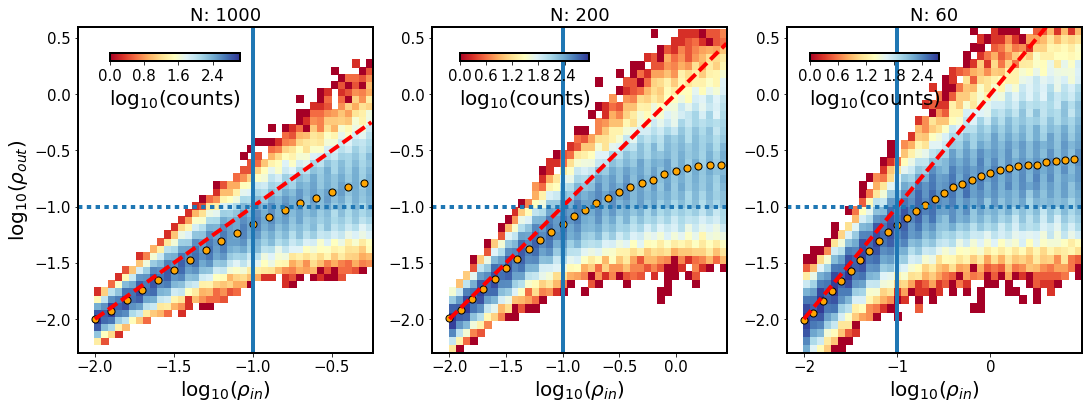

In [33]:
# b) change the number of points 

%matplotlib inline
from scipy.stats import binned_statistic_2d

outDir = '../data_products/DRW_Kozlowski_Simulate/fit_results/'

# a ) keep  noise = 0.001 , random sampling , iterate over Npts .... 

set_lims = True  
xmin, xmax = -2.1, 1.5 # in logspace 
ymin, ymax = -2.3, 0.6
sampling = 'random'
noise = 0.001
# colorbar x0 location ... 
x0_cax = [0.15, 0.42, 0.69]

fig,axs = plt.subplots(1,3,figsize=(18,6))
col = 0
for N_obs in [1000,200,60] :
    # select axis 
    ax = axs[col]
    
    # read-in the results... 
    fname  = outDir+'Celerite_fit_params_'+sampling+str(noise)+str(N_obs)+'.npy'    
    params = np.load(fname).item()
    print('In this simulation we used the following settings:\n',params)
    fname = outDir+'Celerite_fit_results_'+sampling+str(noise)+str(N_obs)+'.npy'
    results = np.load(fname)
    
    # Flatten the dictionary ... 
    rho_in = np.zeros(0) 
    rho_out = np.zeros(0) 

    for i in range(len(results)):
        rho_in = np.append(rho_in,  results[i]['rho_in'])
        rho_out = np.append(rho_out, results[i]['rho_out'])
        
    # Plot the 2D histogram... 
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    if set_lims  :
        print('Limiting x and y ')
        mask_x = (xmin < x ) * ( x < xmax )   
        mask_y = (ymin < y) * (y < ymax)
        mask_xy = mask_x * mask_y
        x = x[mask_xy]
        y = y[mask_xy]
        
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # add colorbar ... 
    cax = fig.add_axes([x0_cax[col], 0.8, 0.1,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='--', lw=4, color='red')
    ax.axhline(-1, ls=':', lw=4)
    ax.axvline(-1, ls='-', lw=4)
    
    if set_lims  : 
        #ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.scatter(mean_x[:-1], median_y[:-1], c = 'orange', s=50 , edgecolor='black')

    ax.set_title('N: '+ str(params['N_obs']))
    col += 1 

axs[0].set_ylabel(r'$\log_{10}(\rho_{out})$')

if set_lims : 
    plt.savefig(outDir+'Celerite_fits_lims_'+sampling+'_'+\
                str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')
else : 
    plt.savefig(outDir+'Celerite_fits_'+sampling+'_'+\
                str(noise)+'_'+str(N_obs)+'.png', bbox_inches='tight')
outDir = '../data_products/DRW_Kozlowski_Simulate/figs/'
plt.savefig(outDir + 'Fig_2_change_N.png', bbox_inches='tight')


In [30]:
params

{'N_obs': 1000, 'noise': 0.1, 'sampling': 'random'}

## Calculating the median... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


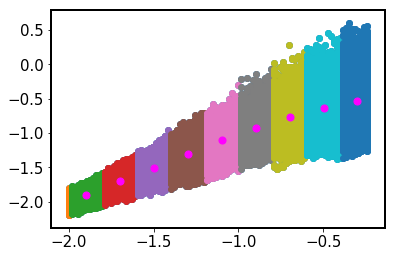

In [41]:
x = np.log10(rho_in)
y = np.log10(rho_out)
fig,ax = plt.subplots()
ax.scatter(x,y)
xlim = ax.get_xlim()

min_x, max_x , step_size = xlim[0],xlim[1], 0.2
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    ax.scatter(x[mask], y[mask])
    
ax.scatter(mean_x[1:], median_y[1:], c = 'magenta', s=50)

In [29]:
print(mean_x)

[-2.09784002 -1.89784002 -1.69784002 -1.49784002 -1.29784002 -1.09784002
 -0.89784002 -0.69784002 -0.49784002 -0.29784002]


In [19]:
# Median of the log(y) is not the log(median(y)) .... 
mean_x = np.arange(xlim[0], xlim[1], 0.2)
median_y = np.zeros(len(mean_x)-1)
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  (mean_x[j]< x )*(x<  mean_x[j+1])
    print(x[mask])
    median_y[j] = np.log10(np.median(rho_out[mask]))


[-1.99 -1.98 -1.97 -1.96 -1.95 -1.94 -1.93 -1.92 -1.91 -1.9  -1.89 -1.88
 -1.87 -1.86 -1.85 -1.84 -1.83 -1.82 -1.81]
[-1.8  -1.79 -1.78 -1.77 -1.76 -1.75 -1.74 -1.73 -1.72 -1.71 -1.7  -1.69
 -1.68 -1.67 -1.66 -1.65 -1.64 -1.63 -1.62 -1.61]
[-1.6  -1.59 -1.58 -1.57 -1.56 -1.55 -1.54 -1.53 -1.52 -1.51 -1.5  -1.49
 -1.48 -1.47 -1.46 -1.45 -1.44 -1.43 -1.42 -1.41]
[-1.4  -1.39 -1.38 -1.37 -1.36 -1.35 -1.34 -1.33 -1.32 -1.31 -1.3  -1.29
 -1.28 -1.27 -1.26 -1.25 -1.24 -1.23 -1.22 -1.21]
[-1.2  -1.19 -1.18 -1.17 -1.16 -1.15 -1.14 -1.13 -1.12 -1.11 -1.1  -1.09
 -1.08 -1.07 -1.06 -1.05 -1.04 -1.03 -1.02 -1.01]
[-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0.91 -0.9  -0.89
 -0.88 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81]
[-0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69
 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61]
[-0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54 -0.53 -0.52 -0.51 -0.5  -0.49
 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100000 but corresponding boolean dimension is 176


In [12]:
median_y

array([-1.903483  , -1.60400902, -1.28369297, -0.88823395, -0.82123194,
       -1.70193715, -1.41069573, -1.05282162])

In [ ]:
mean_x = np.arange(xlim[0], xlim[1], 0.2)
median_y = np.zeros(len(mean_x)-1)
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  (mean_x[j]< x )*(x<  mean_x[j+1])
    median_y[j] = np.median(y[mask])